# Introduction

Congratulations! You have just been hired to lead the data science efforts at DataSciencester, the social network for data scientist.

It's your first day on the job at DataSciencester, and the VP of Networking is full of questions about your users.
To this end, he gives you a dump of the entire DataSciencester network.
This consists of a list of users, each represented by a `dict` that contains that user's `id` and name.

In [1]:
users = [
    {"id": 0, "name": "Hero"},
    {"id": 1 , "name":"Dunn"},
    {"id": 2, "name":"Sue"},
    {"id": 3, "name":"Chi"},
    {"id": 4, "name":"Thor"},
    {"id": 5, "name":"Clive"},
    {"id": 6, "name":"Hicks"},
    {"id": 7, "name":"Devin"},
    {"id": 8, "name":"Kate"},
    {"id": 9, "name":"Klein"},
]

He also gives you the "friendship" data, represented as a list of pairs of IDs.

In [2]:
friendship_pairs = [(0, 1),(0, 2),(1, 2),(1, 3),(2, 3),(3, 4),
                    (4, 5),(5, 6),(5, 7),(6, 8),(7, 8),(8, 9),]

For example, the tuple (0, 1) indicates that the data scientist with `id` 0 (Hero) and the data scientist with `id` 1 (Dunn) are friends.

Having friendships represented as a list of pairs is not the easiest way to work with them.
To find all the friendships for user 1, you would have to iterate over every pair looking for pairs containing 1. If you had lots of pairs, this would take a very long time.

Instead , we will create a `dict` where the keys are user `id`s and the values are lists of friend `id`s.
(Looking up things in a `dict` is very fast.)

We'll still have to look up every pair to create the `dict`, but we only have to do that once.

In [3]:
# Initialise the dict with an empty list for each user id:
friendships = {user['id']: [] for user in users}


In [4]:
friendships

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

In [5]:
# loop over the friendship pairs to populate it:
for i, j in friendship_pairs:
    friendships[i].append(j) # add j as a friend of user i
    friendships[j].append(i) # add i as a friend of user j

In [6]:
friendships

{0: [1, 2],
 1: [0, 2, 3],
 2: [0, 1, 3],
 3: [1, 2, 4],
 4: [3, 5],
 5: [4, 6, 7],
 6: [5, 8],
 7: [5, 8],
 8: [6, 7, 9],
 9: [8]}

Now that we have the friendship in a `dict`, we can easily ask questions of our graph, like "*What's the average number of connections*?"

First we find the *total* number of connections, by summing up the lengths of all the friends lists.

In [7]:
def number_of_friends(user):
    """How many friends does _user_ have?"""
    user_id = user["id"]
    friend_id = friendships[user_id]
    return len(friend_id)

total_connections = sum(number_of_friends(user) for user in users)

In [8]:
number_of_friends(users[0])

2

In [9]:
number_of_friends(users[5])

3

In [10]:
total_connections

24

And then we just divide by the numbers of users:

In [11]:
num_users = len(users) # len of the user list
avg_connections = total_connections / num_users # 24 / 10 == 2.4

In [12]:
avg_connections

2.4

It is also easy to find the most connected people, they are the people who have the largest number of friends.

Since there is not very many users, we can simply sort them from "most friends" to "least friends"

In [13]:
# Create a list (user_id, number_of_friends).
num_of_friends_by_id = [(user["id"], number_of_friends(user))
                        for user in users]

# Sort the list
num_of_friends_by_id.sort(
# by num_friends
key=lambda id_and_friends: id_and_friends[1],
    reverse=True) #largest to smallest

In [14]:
num_of_friends_by_id

[(1, 3),
 (2, 3),
 (3, 3),
 (5, 3),
 (8, 3),
 (0, 2),
 (4, 2),
 (6, 2),
 (7, 2),
 (9, 1)]

One way to think of what we have done is as a way of identifying people who are somehow central to the network.
In fact, what we have just computed is the network metric *degree centrality*

## Data Scientists You May Know

While you are still filling in your new-hire paperwork, the VP of Fraternisation comes by your desk.

She wants to encourage more connections among your members, and she asks you to design a "Data Scientist You May Know" suggester.

Your first instinct is to suggest that users might know the friends of their friends.
So you write some code to iterate over their friends and collect the friends' friends.

In [15]:
def foaf_ids_bad(user):
    """foaf is short for 'friend of a friend' """
    return[foaf_id for friend_id in friendships[user["id"]]
           for foaf_id in friendships[friend_id]]

In [16]:
foaf_ids_bad(users[0])

[0, 2, 3, 0, 1, 3]

This is including user 0 twice, since Hero is indeed friends with both of his friends.
It also includes user 3 twice, as Chi is reachable through two different friends.

In [17]:
print(friendships[0])
print(friendships[1])
print(friendships[2])

[1, 2]
[0, 2, 3]
[0, 1, 3]


Knowing that people are friends of friends in multiple ways seems like interseting information, so maybe instead we should produce a *count* of mutual friends. And we should perhaps exclude people already known to the user:

In [18]:
from collections import Counter

def friends_of_friends(user):
    user_id = user["id"]
    return Counter(
        foaf_id 
        for friend_id in friendships[user_id]                 # For each of my friends,
        for foaf_id in friendships[friend_id]                 # find their friends
        if foaf_id != user_id                                 # who arent me
        and foaf_id not in friendships[user_id]               # and aren't my friends
        )

In [19]:
friends_of_friends(users[3])

Counter({0: 2, 5: 1})

In [20]:
friends_of_friends(users[0])

Counter({3: 2})

As a data scientist, you know that you also might enjoy meeting users with similar interests.
(This is a good example of the "substantive expertise" aspect of data science.) After asking around, you manage to get your hands on this data, as a list of pairs(user_id, interest):

In [21]:
interests = [(0, "Hadoop"),(0, "Big Data"),(0, "HBase"),(0, "Java"),
            (0, "Spark"),(0, "Storm"),(0, "Cassandra"),
            (1, "NoSQL"),(1, "MongoDB"),(1, "Cassandra"),(1, "HBase"),
            (1, "Postgres"),(2, "Python"),(2, "scikit-learn"),(2, "scipy"),
            (2, "numpy"),(2, "statsmodels"),(2, "pandas"),(3, "R"),(3, "Python"),
            (3, "statistics"),(3, "regression"),(3, "probability"),
            (4, "machine learning"),(4, "regression"),(4, "decision trees"),
            (4, "libsvm"),(5, "Python"),(5, "programming languages"),(6, "statistics"),
            (6, "probability"),(6, "mathematics"),(6, "theory"),
            (7, "machine learning"),(7, "scikit-learn"),(7, "Mahout"),
            (7, "neural networks"),(8, "neural networks"),(8, "deep learning"),
            (8, "Big Data"),(8, "artificial intelligence"),(9, "Hadoop"),
            (9, "Java"),(9, "MapReduce"),(9, "Big Data")
           ]

For example, Hero(id 0) ha no friends in common with Klein(id 9), but they both share interests in Java and big data.

It is easy to build a function that finds users with a certain interest:

In [22]:
def data_scientists_who_like(target_interest):
    """Find the ids of all users who like the target interest"""
    return [user_id
            for user_id, user_interest in interests
            if user_interest == target_interest]

In [23]:
data_scientists_who_like("Python")

[2, 3, 5]

In [24]:
data_scientists_who_like("Big Data")

[0, 8, 9]

This works, however it has to examine the whole list of interests for every search. 
If we have a lot of users and interests (or if we just want to do a lot of searches), we are probably better off building an index from interests to users:

In [25]:
from collections import defaultdict

#keys are interests, values are lists of user_ids with that interest
user_ids_by_interest = defaultdict(list)

for user_id, interest in interests:
    user_ids_by_interest[interest].append(user_id)

In [26]:
user_ids_by_interest

defaultdict(list,
            {'Hadoop': [0, 9],
             'Big Data': [0, 8, 9],
             'HBase': [0, 1],
             'Java': [0, 9],
             'Spark': [0],
             'Storm': [0],
             'Cassandra': [0, 1],
             'NoSQL': [1],
             'MongoDB': [1],
             'Postgres': [1],
             'Python': [2, 3, 5],
             'scikit-learn': [2, 7],
             'scipy': [2],
             'numpy': [2],
             'statsmodels': [2],
             'pandas': [2],
             'R': [3],
             'statistics': [3, 6],
             'regression': [3, 4],
             'probability': [3, 6],
             'machine learning': [4, 7],
             'decision trees': [4],
             'libsvm': [4],
             'programming languages': [5],
             'mathematics': [6],
             'theory': [6],
             'Mahout': [7],
             'neural networks': [7, 8],
             'deep learning': [8],
             'artificial intelligence': [8],
          

In [27]:
user_ids_by_interest["Python"]

[2, 3, 5]

In [28]:
user_ids_by_interest["Java"]

[0, 9]

And another from users to interests:

In [29]:
# keys are user_ids, values are lists of user_ids with that interest

interests_by_user_id = defaultdict(list)

for user_id, interest in interests:
    interests_by_user_id[user_id].append(interest)

In [30]:
interests_by_user_id[0]

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']

In [31]:
interests_by_user_id[9]

['Hadoop', 'Java', 'MapReduce', 'Big Data']

In [32]:
interests_by_user_id[1]

['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']

Now it is easy to find who has the most interests in common with a given user:
* Iterate over the user's interests.
* For each interest, iterate over the other users with that interest.
* Keep count of how many times we see each other user.

In [33]:
def most_common_interests_with(user):
    return Counter(
        interested_user_id
        for interest in interests_by_user_id[user["id"]]
        for interested_user_id in user_ids_by_interest[interest]
        if interested_user_id != user["id"]
    )

In [34]:
most_common_interests_with(users[0])

Counter({9: 3, 8: 1, 1: 2})

We could then use this to build a richer "Data Scientists You May Know" feature based on a combination of mutual friends and mutual interests. We will explore these kinds of applications in a Chapter 23.

## Salaries and Experience

Right as you are about to head to lunch, the VP of Public Relations asks if you can provide some fun facts about how much data scientists earn. Salary data is of coursesensitive, but he manages to provide you an anonymous dataset containing each user's salary and tenure as a data scientist (in years):

In [35]:
salaries_and_tenures = [(83000, 8.7), (88000, 8.1),
                        (48000, 0.7), (76000, 6),
                        (69000, 6.5), (76000, 7.5),
                        (60000, 2.5), (83000, 10),
                        (48000, 1.9), (63000, 4.2),]

In [37]:
# keys are years, values are lists of the salaries for each tenure

salary_by_tenure = defaultdict(list)

for salary, tenure in salaries_and_tenures:
    salary_by_tenure[tenure].append(salary)
    
# keys are years, each value is average salary for that tenure.

average_salary_by_tenure = {
    tenure: sum(salaries) / len(salaries)
    for tenure, salaries in salary_by_tenure.items()
}

In [38]:
salary_by_tenure

defaultdict(list,
            {8.7: [83000],
             8.1: [88000],
             0.7: [48000],
             6: [76000],
             6.5: [69000],
             7.5: [76000],
             2.5: [60000],
             10: [83000],
             1.9: [48000],
             4.2: [63000]})

In [39]:
average_salary_by_tenure

{8.7: 83000.0,
 8.1: 88000.0,
 0.7: 48000.0,
 6: 76000.0,
 6.5: 69000.0,
 7.5: 76000.0,
 2.5: 60000.0,
 10: 83000.0,
 1.9: 48000.0,
 4.2: 63000.0}

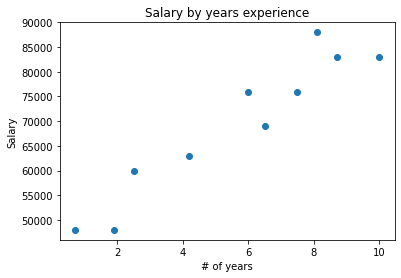

In [42]:
from matplotlib import pyplot as plt

years = [0.7, 1.9, 2.5, 4.2, 6, 6.5, 7.5, 8.1, 8.7, 10]
salary = [48000, 48000, 60000, 63000, 76000, 69000, 76000, 88000, 83000, 83000]

plt.scatter(years, salary)

plt.title('Salary by years experience')
plt.xlabel('# of years')
plt.ylabel('Salary')
plt.show();

This turns out to be not particularly useful, as none of the users have the same tenure, which means we're just reporting the individual user's salaries.

It may be more helpful to bucket the tenures:

In [43]:
def tenure_bucket(tenure):
    if tenure < 2:
        return "less than two"
    elif tenure < 5:
        return "between two and five"
    else: 
        return "more than five"

Then we can group together the salaries corresponding to each bucket.

In [44]:
# Keys are tenure_buckets, values are lists of salaries for that bucket

salary_by_tenure_bucket = defaultdict(list)

for salary, tenure in salaries_and_tenures:
    bucket = tenure_bucket(tenure)
    salary_by_tenure_bucket[bucket].append(salary)

and finally compute the average salary for each group.
    

In [45]:
# Keys are tenure buckets, values are average salary for that bucket.

average_salary_by_bucket = {
    tenure_bucket: sum(salaries) / len(salaries)
    for tenure_bucket, salaries in salary_by_tenure_bucket.items()
}

which is more interesting:

In [46]:
average_salary_by_bucket

{'more than five': 79166.66666666667,
 'less than two': 48000.0,
 'between two and five': 61500.0}

And now we have our soundbite: **"Data scientists with more than five years' experience earn 65% more than data scientists with little or no experience "**

## Paid Accounts

When you get back to your desk, the VP of Revenue is waiting for you. She wants to better understand which users pay for accounts and which don't.

You notice that there seems to be a correspondence between years of experience and paid accounts:

0.7 paid
1.9 unpaid
2.5 paid
4.2 unpaid
6.0 unpaid
6.5 unpaid
7.5 unpaid
8.1 unpaid
8.7 paid
10.0 paid

If you wanted to create a a model, though this is definitely not enough data to base a model on. You might try to predict "paid" for users with very few and very many years of experience, and "unpaid" for users with middling amounts of experience: 

In [50]:
def predict_paid_or_unpaid(years_experience):
    if years_experience < 3.0:
        return "paid"
    elif years_experience < 8.5:
        return "unpaid"
    else:
        return "paid"

In [51]:
predict_paid_or_unpaid(6)

'unpaid'

In [52]:
predict_paid_or_unpaid(2)

'paid'

In [ ]:
With more data (and more mathematics), we could build a model predicting the likelhood that a user would pay